<a href="https://colab.research.google.com/github/AquaSpare/deep_learning_assignment_3/blob/main/unet_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from skimage import io
from google.colab import drive
from sklearn.metrics import ConfusionMatrixDisplay
import statistics

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Loading the dataset

In [ ]:
# Class for loading the warwick dataset
class warwick_dataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.transform = transform
    self.dirlist = sorted(os.listdir(root_dir))

    self.target_paths = []
    self.image_paths = []

    for path in self.dirlist:
      if path[0] == 'l':
        self.target_paths.append(os.path.join(self.root_dir, path))
      else:
        self.image_paths.append(os.path.join(self.root_dir, path))

  def __len__(self):
    return len(self.target_paths)

  def __getitem__(self, index):
    image = io.imread(self.image_paths[index])
    target = io.imread(self.target_paths[index])

    if self.transform:
      image = self.transform(image)
      target = self.transform(target)

      image = image[:2,:,:]

    return (image, target)

In [ ]:
root_dir_test = '/content/drive/MyDrive/Datasets/WARWICK/Test'
root_dir_train = '/content/drive/MyDrive/Datasets/WARWICK/Train'
csv_file = 'Grade.csv'

# create the dataset and divide in train, validation and test subsets

train_set = warwick_dataset(root_dir=root_dir_train, transform=transforms.ToTensor())

test_set = warwick_dataset(root_dir=root_dir_test, transform=transforms.ToTensor())
test_set, val_set = torch.utils.data.random_split(test_set, [30, 30])

In [ ]:
# Set the device to gpu if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Define hyperparameters

In [ ]:
# Define hyperparameters
learning_rate = 0.001
batch_size = 15
num_epochs = 300
momentum = 0.9
weight_decay = 0.05

In [ ]:
# Create dataloaders
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True)

In [ ]:
# Code to show an image
index = 25
x,y = train_set[index]
print(y)
# plt.imshow(y[0])

In [ ]:
class model_1(nn.Module):
  def __init__(self):
    super(model_1, self).__init__()
    
    self.conv1 = nn.Conv2d(2, 8, 3, 1, 1)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(8, 16, 3, 1, 1)
    self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
    self.tconv1 = nn.ConvTranspose2d(32, 16, 4, 2, 1)
    self.tconv2 = nn.ConvTranspose2d(16, 8, 4, 2, 1)
    self.tconv3 = nn.ConvTranspose2d(8, 4, 4, 2, 1)
    self.conv_final = nn.Conv2d(4, 2, 1, 1, 0)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = F.relu(self.conv3(x))
    x = self.pool(x)

    x = F.relu(self.tconv1(x))
    x = F.relu(self.tconv2(x))
    x = F.relu(self.tconv3(x))

    x = self.conv_final(x)

    return x

model = model_1().to(device)

In [ ]:
# Model using tan hyperbolic activation functions
class model_2(nn.Module):
  def __init__(self):
    super(model_2, self).__init__()
    
    self.conv1 = nn.Conv2d(2, 8, 3, 1, 1)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(8, 16, 3, 1, 1)
    self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
    self.tconv1 = nn.ConvTranspose2d(32, 16, 4, 2, 1)
    self.tconv2 = nn.ConvTranspose2d(16, 8, 4, 2, 1)
    self.tconv3 = nn.ConvTranspose2d(8, 4, 4, 2, 1)
    self.conv_final = nn.Conv2d(4, 2, 1, 1, 0)

  def forward(self, x):
    x = F.tanh(self.conv1(x))
    x = self.pool(x)
    x = F.tanh(self.conv2(x))
    x = self.pool(x)
    x = F.tanh(self.conv3(x))
    x = self.pool(x)

    x = F.tanh(self.tconv1(x))
    x = F.tanh(self.tconv2(x))
    x = F.tanh(self.tconv3(x))

    x = self.conv_final(x)

    return x

model = model_2().to(device)

In [ ]:
# Model using a 3x3 filter kernel to the output.
class model_3(nn.Module):
  def __init__(self):
    super(model_3, self).__init__()
    
    self.conv1 = nn.Conv2d(2, 8, 3, 1, 1)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(8, 16, 3, 1, 1)
    self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
    self.tconv1 = nn.ConvTranspose2d(32, 16, 4, 2, 1)
    self.tconv2 = nn.ConvTranspose2d(16, 8, 4, 2, 1)
    self.tconv3 = nn.ConvTranspose2d(8, 4, 4, 2, 1)
    self.conv_final = nn.Conv2d(4, 2, 3, 1, 1)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = F.relu(self.conv3(x))
    x = self.pool(x)

    x = F.relu(self.tconv1(x))
    x = F.relu(self.tconv2(x))
    x = F.relu(self.tconv3(x))

    x = self.conv_final(x)

    return x

model = model_3().to(device)

In [ ]:
# model using skip connections
class model_skip(nn.Module):
  def __init__(self):
    super(model_skip, self).__init__()
    
    self.conv1 = nn.Conv2d(2, 8, 3, 1, 1)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(8, 16, 3, 1, 1)
    self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)

    self.tconv1 = nn.ConvTranspose2d(32, 32, 4, 2, 1)
    self.tconv2 = nn.ConvTranspose2d(16, 16, 4, 2, 1)
    self.tconv3 = nn.ConvTranspose2d(8, 8, 4, 2, 1)

    self.conv_final = nn.Conv2d(8, 2, 1, 1, 0)

    self.conv_bottom0 = nn.Conv2d(32,32,3,1,1)
    self.conv_bottom1 = nn.Conv2d(64,16,3,1,1)
    self.conv_bottom2 = nn.Conv2d(32,8,3,1,1)
    self.conv_bottom3 = nn.Conv2d(16,8,3,1,1)

  def forward(self, x):
    x1 = F.relu(self.conv1(x))
    x2 = self.pool(x1)
    x3 = F.relu(self.conv2(x2))
    x4 = self.pool(x3)
    x5 = F.relu(self.conv3(x4))
    x6 = self.pool(x5)

    x7 = F.relu(self.conv_bottom0(x6))

    x8 = torch.cat((self.tconv1(x7),x5),1)
    x9 = F.relu(self.conv_bottom1(x8))
    x10 = torch.cat((self.tconv2(x9),x3),1)
    x11 = F.relu(self.conv_bottom2(x10))
    x12 = torch.cat((self.tconv3(x11),x1),1)
    x13 = F.relu(self.conv_bottom3(x12))

    x14 = self.conv_final(x13)

    return x14

model = model_skip().to(device)

In [ ]:
# code for a residual block
class basic_block(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(basic_block, self).__init__()

    self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, 1)
    self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
    self.res_conv = nn.Conv2d(in_channels, out_channels, 1)

  def forward(self, x):

    res = x

    x = F.relu(self.conv1(x))
    x = self.conv2(x) + self.res_conv(res)
    x = F.relu(x)
      
    return x

# the complete network using residual blocks
class residual_network(nn.Module):
  def __init__(self):
    super(residual_network, self).__init__()

    self.resblock1 = basic_block(2, 8)
    self.resblock2 = basic_block(8, 16)
    self.resblock3 = basic_block(16, 32)

    self.tconv1 = nn.ConvTranspose2d(32, 16, 4, 2, 1)
    self.tconv2 = nn.ConvTranspose2d(16, 8, 4, 2, 1)
    self.tconv3 = nn.ConvTranspose2d(8, 4, 4, 2, 1)

    self.conv_final = nn.Conv2d(4, 2, 1)
    self.pool = nn.MaxPool2d(2, 2)
  
  def forward(self, x):
    x = self.resblock1(x)
    x = self.pool(x)
    x = self.resblock2(x)
    x = self.pool(x)
    x = self.resblock3(x)
    x = self.pool(x)

    x = F.relu(self.tconv1(x))
    x = F.relu(self.tconv2(x))
    x = F.relu(self.tconv3(x))

    x = self.conv_final(x)

    return x

model = residual_network().to(device)

In [ ]:
# define loss function and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
# Used for the 2.2 exercise to add L2 regularization
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay=0.0001)

In [ ]:
# function to evaluate accuracy on a given dataset in a loader
def check_accuracy(loader, model):
  model.eval()

  num_correct = 0
  num_samples = 0
  num_pixels = 0
  dice_score = 0

  with torch.no_grad():
    for x, y in loader:
      # Put data on GPU if available
      x = x.to(device)
      y = y.to(device)

      # Evaluate the predictions
      scores = model(x)

      preds = F.softmax(scores, dim=1)
      preds = preds.argmax(dim=1)

      # Count the numbers of correct classified pixels and total number of pixels
      num_correct += (preds == y.squeeze()).sum()
      num_pixels += torch.numel(preds)

      # Computing the Dice Score
      dice_score += (2* (preds*y.squeeze(1)).sum())/((preds + y.squeeze(1)).sum() + 1e-8)
    model.train()
  return dice_score/len(loader)

In [ ]:
losses = []
SDC_test = []
SDC_train = []

In [ ]:
for epoch in range(num_epochs):
  loss = []
  for data, targets in train_loader:
    data = data.to(device)
    targets = targets.to(device)

    scores = model(data)
    J = criterion(scores, targets.squeeze(1).long())

    optimizer.zero_grad()
    J.backward()

    optimizer.step()

    loss.append(J.item())

  losses.append(statistics.mean(loss))

  SDC_train.append(check_accuracy(train_loader, model))
  SDC_test.append(check_accuracy(test_loader, model))

  print(epoch)

Section for creating plots

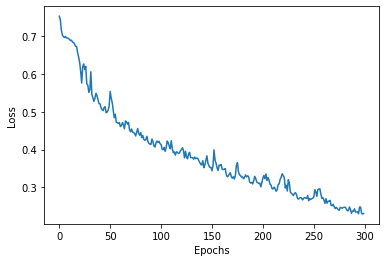

In [ ]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('ploz')

tensor(0.8391, device='cuda:0')


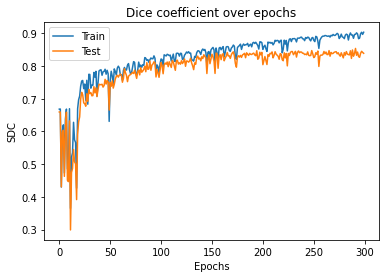

In [ ]:
plt.plot(SDC_train, label='Train')
plt.plot(SDC_test, label='Test')

plt.xlabel('Epochs')
plt.ylabel('SDC')
plt.title('Dice coefficient over epochs')
plt.legend()
plt.savefig('SDC_REG')

print(SDC_test[-1])

In [ ]:
x,y = next(iter(test_loader))

x = x.to(device)
y = y.to(device)

pred = model(x)
pred = F.softmax(pred, dim = 1)
pred = pred.argmax(dim = 1)

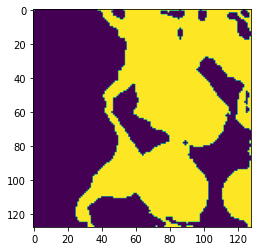

In [ ]:
index = 5
im = pred.to('cpu')
plt.imshow(im[index])
plt.savefig('Test_bad_pred')

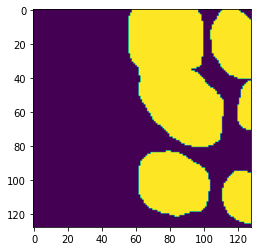

In [ ]:
tar = y.to('cpu')
plt.imshow(tar[index][0])
plt.savefig('Test_bad_target')